<a href="https://colab.research.google.com/github/ibrayoubi10/TER-ALLERGIE/blob/main/ANAL_CLASS_RESP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys
# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

my_local_drive='/content/gdrive/My Drive/Colab Notebooks/TER'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive
%pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/TER


'/content/gdrive/My Drive/Colab Notebooks/TER'

In [3]:
import sys
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/projet_ML")
from MyNLPUtilities import *

In [4]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("all_data.xlsx", engine="openpyxl")

# Display the first few rows
print(df.head())

  Patient_ID Chip_Code Chip_Type Chip_Image_Name   Age Gender  \
0    XPW0001   XPW0001   ISAC_V1             NaN  32.0      M   
1    XPW0002   XPW0002   ISAC_V1             NaN  67.0      M   
2    XPW0003   XPW0003   ISAC_V1             NaN  40.0      M   
3    XPW0004   XPW0004   ISAC_V1             NaN  57.0      F   
4    XPW0005   XPW0005   ISAC_V1             NaN  52.0      F   

   Blood_Month_sample  French_Residence_Department  French_Region  \
0                 3.0                           31             11   
1                 3.0                           11             11   
2                 3.0                           47             10   
3                 3.0                           32             11   
4                 3.0                           31             11   

   Rural_or_urban_area  ...  Tyr_p_2  Ulm_c  Urt_d  Vac_m  Ves_v  Ves_v_1  \
0                    1  ...      NaN    NaN    NaN    NaN    NaN      NaN   
1                    1  ...      NaN    

In [6]:
# Filtrer les lignes où Chip_type == "ISAC_V1"
V1_df = df[df["Chip_Type"] == "ISAC_V1"]

extra_columns = ["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy"]

# Allergènes respiratoires
respiratoire_allergenes = [
    "Aln_g_1", "Alt_a_1", "Alt_a_6", "Amb_a_1", "Art_v_1", "Art_v_3", "Asp_f_1", "Asp_f_3", "Asp_f_6",
    "Bet_v_1", "Bet_v_2", "Bet_v_4", "Bla_g_1", "Bla_g_2", "Bla_g_5", "Bla_g_7", "Blo_t_5",
    "Can_f_1", "Can_f_2", "Can_f_3", "Can_f_5", "Che_a_1", "Cla_h_8", "Cry_j_1", "Cup_a_1", "Cyn_d_1",
    "Der_f_1", "Der_f_2", "Der_p_1", "Der_p_2", "Der_p_10", "Equ_c_1", "Equ_c_3", "Fel_d_1", "Fel_d_2",
    "Fel_d_4", "Mer_a_1", "Mus_m_1", "Ole_e_1", "Ole_e_7", "Ole_e_9", "Par_j_2", "Phl_p_1", "Phl_p_2",
    "Phl_p_4", "Phl_p_5", "Phl_p_6", "Phl_p_7", "Phl_p_11", "Phl_p_12", "Pla_a_1", "Pla_a_2",
    "Pla_a_3", "Pla_l_1"
]

# Allergènes alimentaires
alimentaire_allergenes = [
    "Act_d_1", "Act_d_2", "Act_d_5", "Act_d_8", "Ana_o_2", "Ani_s_1", "Ani_s_3", "Ara_h_1", "Ara_h_2",
    "Ara_h_3", "Ara_h_6", "Ara_h_8", "Ara_h_9", "Ber_e_1", "Bos_d_4", "Bos_d_5", "Bos_d_6", "Bos_d_8",
    "Bos_d_Lactoferrin", "Cor_a_1.0101", "Cor_a_1.0401", "Cor_a_8", "Cor_a_9", "Fag_e_2", "Gad_c_1",
    "Gal_d_1", "Gal_d_2", "Gal_d_3", "Gal_d_5", "Gly_m_4", "Gly_m_5", "Gly_m_6", "Jug_r_1", "Jug_r_2",
    "Jug_r_3", "Mal_d_1", "Pen_m_1", "Pen_m_2", "Pen_m_4", "Pru_p_1", "Pru_p_3", "Sal_k_1", "Ses_i_1",
    "Tri_a_14", "MUXF3", "Hev_b_8", "Hev_b_1", "Hev_b_3", "Hev_b_5", "Hev_b_6.01"
]

# Allergènes aux venins
venin_allergenes = [
    "Api_g_1", "Api_m_1", "Api_m_4", "Pol_d_5", "Lep_d_2"
]


# Sélectionner les colonnes spécifiques
selected_columns = extra_columns + respiratoire_allergenes

# Créer un nouveau dataframe avec les colonnes sélectionnées
V1_data = V1_df[selected_columns]

# Afficher les premières lignes du nouveau dataframe
print(V1_data.head())

  Patient_ID Chip_Code  Allergy_Present  Respiratory_Allergy  Aln_g_1  \
0    XPW0001   XPW0001                1                    1      0.0   
1    XPW0002   XPW0002                1                    1      0.0   
2    XPW0003   XPW0003                1                    1      0.0   
3    XPW0004   XPW0004                1                    0      0.0   
4    XPW0005   XPW0005                1                    1      0.0   

   Alt_a_1  Alt_a_6  Amb_a_1  Art_v_1  Art_v_3  ...  Phl_p_4  Phl_p_5  \
0     8.42      0.0      0.0      0.0      0.0  ...     3.03    13.80   
1     0.00      0.0      0.0      0.0      0.0  ...     0.00     0.00   
2     0.38      0.0      0.0      0.0      0.0  ...     0.00     3.08   
3     0.00      0.0      0.0      0.0      0.0  ...     0.00     0.00   
4     0.00      0.0      0.0      0.0      0.0  ...     0.00     0.00   

   Phl_p_6  Phl_p_7  Phl_p_11  Phl_p_12  Pla_a_1  Pla_a_2  Pla_a_3  Pla_l_1  
0     1.30      0.0       0.0       0.0     

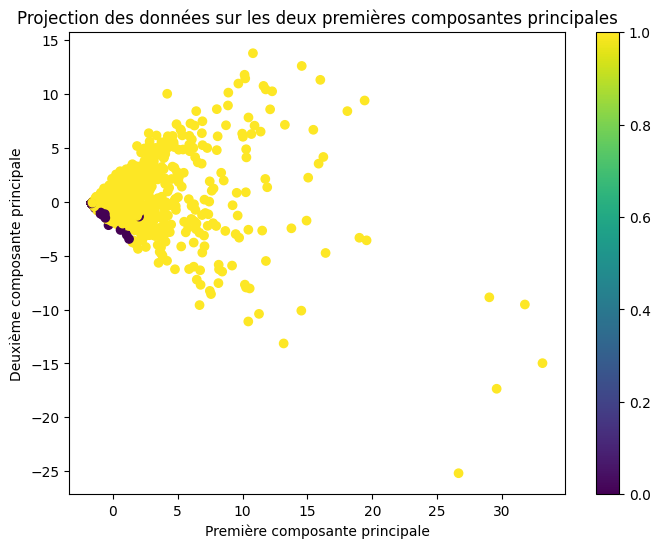

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = V1_data.drop( ["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy"], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible allergie respiratoire

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Projection des données sur les deux premières composantes principales')
plt.show()


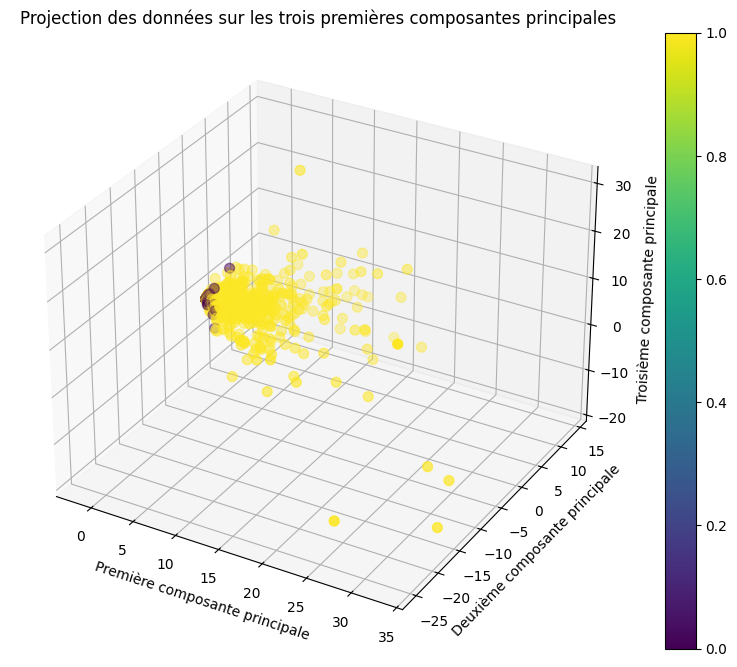

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importer Axes3D pour la visualisation en 3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy"], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible allergie respiratoire

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'ACP
pca = PCA(n_components=3)  # Réduire à 3 dimensions
X_pca = pca.fit_transform(X_scaled)

# Visualisation en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer le graphique en 3D avec une palette de couleurs différente
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', s=50)

# Ajouter une barre de couleurs pour l'espèce (la cible)
plt.colorbar(sc)

# Ajouter des labels et un titre
ax.set_xlabel('Première composante principale')
ax.set_ylabel('Deuxième composante principale')
ax.set_zlabel('Troisième composante principale')
ax.set_title('Projection des données sur les trois premières composantes principales')

# Afficher le graphique
plt.show()

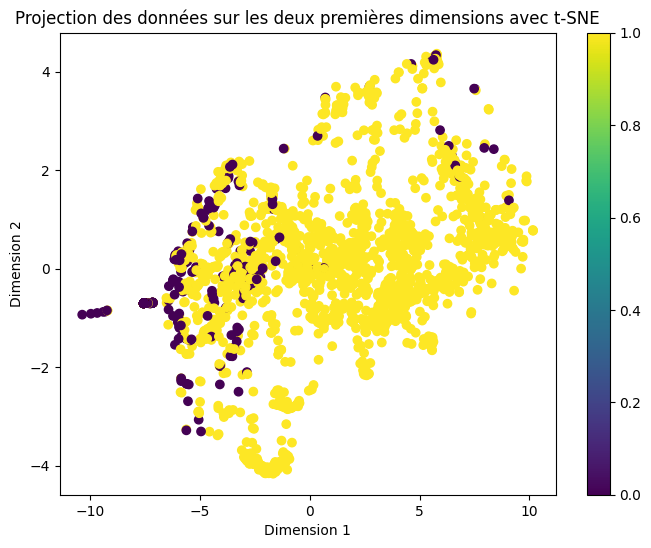

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy" ], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible respiratoire allergie

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # Paramètres : 2 dimensions, perplexity = 30, 300 itérations
X_tsne = tsne.fit_transform(X_scaled)

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar()  # Afficher la barre de couleurs
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projection des données sur les deux premières dimensions avec t-SNE')
plt.show()

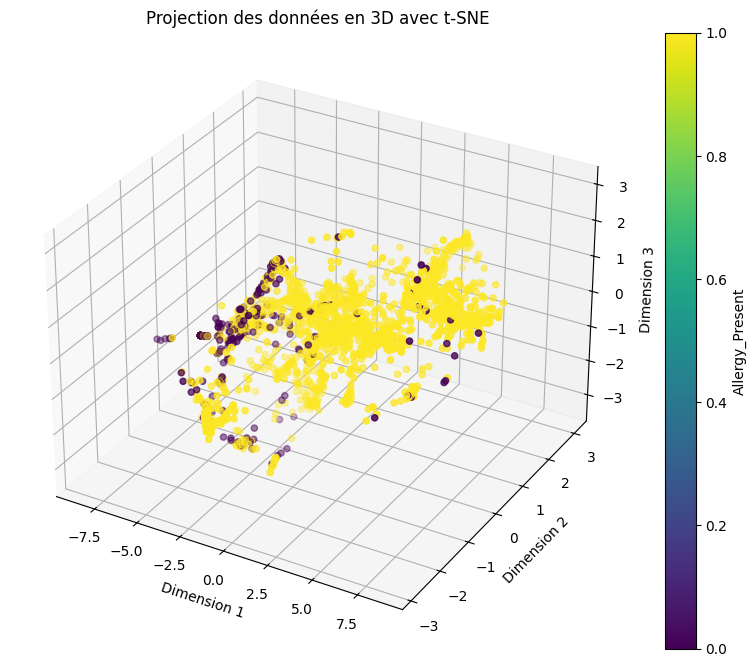

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy" ], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible respiratoire allergie

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)  # Paramètres : 3 dimensions, perplexity = 30, 300 itérations
X_tsne = tsne.fit_transform(X_scaled)

# Visualisation en 3D des résultats
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis')

# Ajouter une barre de couleur
colorbar = plt.colorbar(scatter)
colorbar.set_label('Allergy_Present')

# Ajouter des labels aux axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Projection des données en 3D avec t-SNE')

# Afficher la visualisation
plt.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


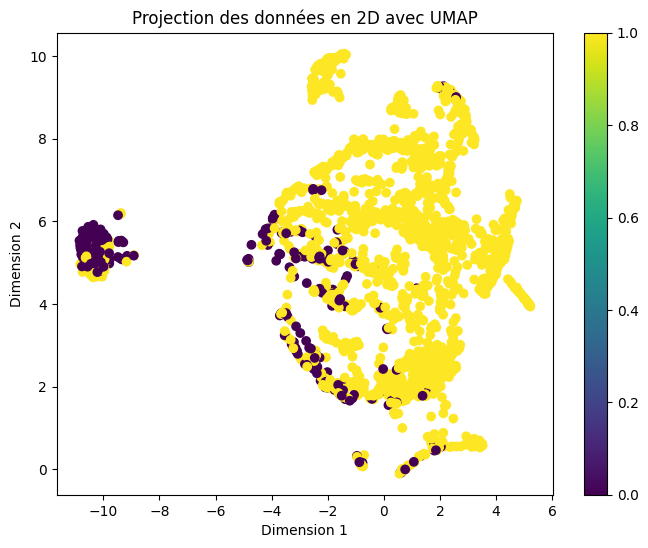

In [18]:
import umap


# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy" ], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible respiratoire allergie

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer UMAP en 2D
umap_model = umap.UMAP(n_components=2, random_state=0)
X_umap = umap_model.fit_transform(X_scaled)

# Visualisation des résultats en 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
plt.colorbar()  # Afficher la barre de couleurs
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projection des données en 2D avec UMAP')
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


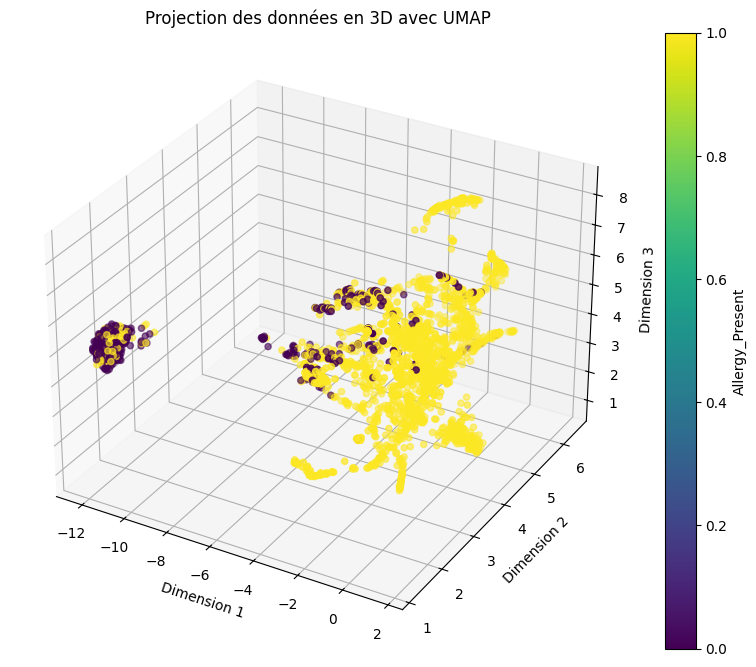

In [17]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Sélectionner les caractéristiques et la cible
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy" ], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible respiratoire allergie

# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer UMAP en 3D
umap_model_3d = umap.UMAP(n_components=3, random_state=0)
X_umap_3d = umap_model_3d.fit_transform(X_scaled)

# Visualisation des résultats en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], c=y, cmap='viridis')

# Ajouter une barre de couleur
colorbar = plt.colorbar(scatter)
colorbar.set_label('Allergy_Present')

# Ajouter des labels aux axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Projection des données en 3D avec UMAP')

# Afficher la visualisation
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy" ], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible respiratoire allergie

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser en jeu d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialiser et entraîner un modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"Précision du modèle : {accuracy:.2f}")
print("\nMatrice de confusion :\n", conf_matrix)
print("\nRapport de classification :\n", class_report)

Précision du modèle : 0.92

Matrice de confusion :
 [[ 79  11]
 [ 26 355]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.88      0.81        90
           1       0.97      0.93      0.95       381

    accuracy                           0.92       471
   macro avg       0.86      0.90      0.88       471
weighted avg       0.93      0.92      0.92       471



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:32:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 SVM 🔹
Précision : 0.81
Matrice de confusion :
 [[  0  90]
 [  0 381]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.81      1.00      0.89       381

    accuracy                           0.81       471
   macro avg       0.40      0.50      0.45       471
weighted avg       0.65      0.81      0.72       471


🔹 KNN 🔹
Précision : 0.87
Matrice de confusion :
 [[ 73  17]
 [ 44 337]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.62      0.81      0.71        90
           1       0.95      0.88      0.92       381

    accuracy                           0.87       471
   macro avg       0.79      0.85      0.81       471
weighted avg       0.89      0.87      0.88       471


🔹 XGBoost 🔹
Précision : 0.91
Matrice de confusion :
 [[ 78  12]
 [ 30 351]]
Rapport de classification :
               precision    recall  f

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


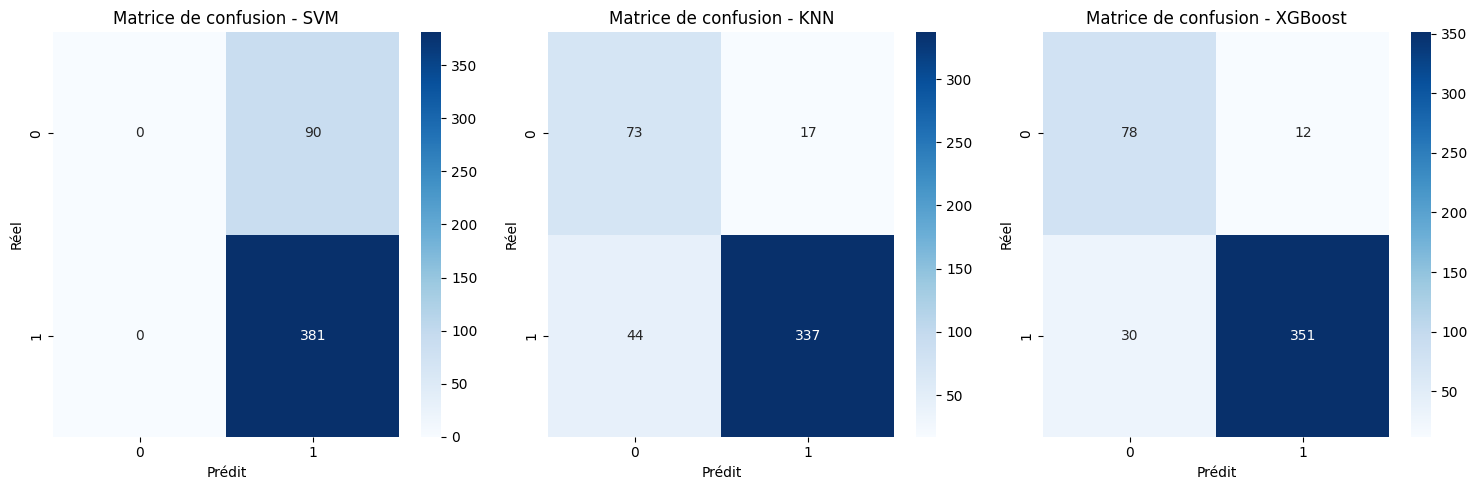

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Préparation des données
X = V1_data.drop(["Patient_ID", "Chip_Code", "Allergy_Present", "Respiratory_Allergy" ], axis=1)
y = V1_data['Respiratory_Allergy']  # La cible respiratoire allergie

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 📌 1️⃣ Modèle SVM
svm_model = SVC(kernel="rbf", C=1, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# 📌 2️⃣ Modèle KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# 📌 3️⃣ Modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 📌 Évaluation des modèles
models = {"SVM": y_pred_svm, "KNN": y_pred_knn, "XGBoost": y_pred_xgb}
for model_name, y_pred in models.items():
    print(f"\n🔹 {model_name} 🔹")
    print(f"Précision : {accuracy_score(y_test, y_pred):.2f}")
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("Rapport de classification :\n", classification_report(y_test, y_pred))

# 📌 Visualisation des matrices de confusion
plt.figure(figsize=(15, 5))
for i, (model_name, y_pred) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")

plt.tight_layout()
plt.show()